


###  **Классификация заболеваний маниоки**
        
         В этой задаче предоставлен набор данных из 5 мелкозернистых категорий заболеваний листьев маниоки с 9436 помеченными изображениями, собранными в ходе регулярного обследования в Уганде, в основном краудсорсинговыми от фермеров, фотографируемых их садов, и аннотированных экспертами Национального научно-исследовательского института ресурсов для сельскохозяйственных культур (NaCRRI) в сотрудничестве с лабораторией искусственного интеллекта в Университете Макарере, Кампала.
       Цель состоит в том, чтобы построить модель для классификации данного изображения по этим 4 категориям заболеваний или 5-й категории, указывающей на здоровый лист.

In [ ]:
## Загружаем данные с Kaggle

#!pip uninstall -y kaggle
#!pip install --upgrade pip
#!pip install kaggle==1.5.6

#from google.colab import files
#files.upload()

#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/

#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle competitions download -c cassava-leaf-disease-classification
#!unzip cassava-leaf-disease-classification.zip


## Данный код для решение задачи на платаформе Google colab

In [4]:
## Устанавливаем путь к папкам с фотографиями для обучения и для теста
train_path = '../input/ammi-2021-convnets/train/train'
test_path = '../input/ammi-2021-convnets/test/test/0'
sample_submission_path = '../input/ammi-2021-convnets/sample_submission_file.csv'

In [101]:
## Подключаем необходимые библиотеки
!pip install efficientnet_pytorch

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch import nn
from torchvision.models import resnet18, resnet34, resnet50
from efficientnet_pytorch import EfficientNet
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import os.path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm_notebook

from IPython.display import clear_output
%matplotlib inline

In [102]:
## Посмотрим на то, как должен быть представлен ответ
df_result = pd.read_csv(sample_submission_path)
df_result.head()

,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


In [103]:
## Посмотрим на распределение классов фотографий
print('cbb: {},'.format(len(os.listdir(train_path + '/cbb'))), 'cbsd: {},'.format(len(os.listdir(train_path + '/cbsd'))), 
     'cgm: {},'.format(len(os.listdir(train_path + '/cgm'))), 'cmd: {},'.format(len(os.listdir(train_path + '/cmd'))), 
     'healthy: {}'.format(len(os.listdir(train_path + '/healthy'))))

cbb: 466, cbsd: 1443, cgm: 773, cmd: 2658, healthy: 316


Видим, что классы рапределены не равномерно. Но с применением аугментации данного количества фотографий для каждого класса должно хватить для обучения

## 1. Определение необходимых функций и классов
1. Определение функций для отрисовки фотгорафий и графика обучения
2. Создание собственной имплементации нейросетей VGG и ResNet
3. Определение функций для обучения нейросетей

In [104]:
## Создадим необходимые функции 
## plot_history - функция отображает график обучения модели
## plot_images - функция для отображения 1 случайной фотографий из валидационной выборки с указанием настоящей метки класса,
## а также предсказанной метки и уверенностью модели в ней
    

def img_show(image, label, y_pred, confidense):
    

    image = image.view(3, image.shape[2], image.shape[3])
    to_Pil = transforms.ToPILImage()
    image = to_Pil(image)
    plt.figure(figsize = (10,6))
    plt.imshow(image)
    plt.title('Label: {} \n Pred: {}, Confidence: {}'.format(label, y_pred, confidense), fontsize=14)


def plot_history(train_history, val_history, title):

    plt.figure(figsize = (10, 6))
    plt.title(title, fontsize=14)

    plt.plot(train_history, label='train', zorder=0, color='orange')
    
    steps = np.linspace(len(train_history)/len(val_history), len(train_history), len(val_history))
    
    plt.scatter(steps, val_history, marker='o', s=70, zorder=1, color='blue')

    plt.legend(loc='best', fontsize=12)
    plt.xlabel('train_steps', fontsize=12)
    plt.grid()

    plt.show()
    
    
def plot_images(model, valset):
    
    idx = int(np.random.randint(0, valset.__len__(), size=1))
    image = valset[idx][0]
    label = valset[idx][1]
    
    model.eval()
    model.to('cpu')
    with torch.no_grad():
        image = image.view(1, 3, image.shape[1], image.shape[2])
        pred = model(image)
        pred_proba = nn.Softmax()(pred)
        pred_classes = torch.argmax(pred_proba)
        pred_proba = round(float(torch.max(pred_proba)), 2)
        
    img_show(image, label, pred_classes, pred_proba)  

In [105]:
## Создадим собственную имплементацию нейросетей VGG и ResNet 

class VGGBLock(nn.Module):
    """ Класс определяющий базовый блок VGG """
    def __init__(self, in_planes, planes, maxpool_pading=0, stride=1):
        super(VGGBLock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=1, padding=1)
        self.norm1 =  nn.BatchNorm2d(planes)
        self.relu =  nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=stride, padding=1)
        self.norm2 = nn.BatchNorm2d(planes)
        self.maxpool = nn.MaxPool2d(2, padding=maxpool_pading)
        self.block = nn.Sequential(self.conv1, self.norm1, self.relu, self.conv2, self.norm2, self.relu,)
                                   
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        return out

class my_VGGNet(nn.Module):
    """ Класс собирающий базовые блоки и формирующий модель VGG"""

    def __init__(self, num_blocks, num_classes, image_size=224):
        super(my_VGGNet, self).__init__()

        blocks = [VGGBLock(3, 32)]
        i = 32
        for j in range(1, num_blocks):
            if j == 5:
                blocks.append(VGGBLock(i, int(2*i), maxpool_pading=1))
            else:
                blocks.append(VGGBLock(i, int(2*i)))
            i = int(2*i)
        self.blocks = nn.Sequential(*blocks)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(nn.Linear(in_features=16384, out_features=1024),
                                    nn.ReLU())
        
        self.out = nn.Linear(1024, num_classes)

    def forward(self, x):

        x = self.blocks(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.out(x)

        return x


class BasicRedusialBlock(nn.Module):
    """ Класс определяющий базовый блок нейросети ResNet"""

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicRedusialBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1)
        self.norm = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self.downsample = downsample

    def forward(self, x):

        Inception = x

        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm(out)

        if self.downsample is not None:
            Inception = self.downsample(Inception)

        out += Inception

        return self.relu(out)
        

class my_ResNet(nn.Module):
    """ Класс для опрделения модели ResNet"""

    def __init__(self, block, layers, num_classes):
        super(my_ResNet, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()
                                   )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, 128, layers[0], 2)
        self.layer2 = self.make_layer(block, 128, 256, layers[1], 2)
        self.layer3 = self.make_layer(block, 256, 512, layers[2], 2)

        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        self.out = nn.Linear(in_features=4608, out_features=num_classes)


    def make_layer(self, block, in_planes, planes, num_blocks, stride):
        downsample = None
        if (stride != 1) or (in_planes != out_planes):
            downsample = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride),
                                       nn.BatchNorm2d(planes)
                                       )
            
        layers = [block(in_planes, planes, stride, downsample)]
        in_planes = planes
        for _ in range(1, num_blocks):
            layers.append(block(in_planes, planes))
        
        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)

        x = self.flatten(x)
        x = self.out(x)

        return x

In [106]:
## Определим функции для обучения моделей
## fit_epoch - обучение модели для одной эпохи на обучающей выборке
## val_epoch - расчет метрик на валлидационной выборке
## train_net - полный цикл обучения модели и отоброжение графика обучения
## predict - функция для предсказания результатов на тестовой выборке
## Основная метрика в данной задаче - accuracy, но также мы будем рассчитывать f1_score
## Для обучения будем использовать метод градиентного спуска Adam, а также логистическую функцию потерь

def fit_epoch(model, data_loader, criterion, optimizer,  device='cuda'):
    train_loss, train_accuracy = [], []
    train_run_loss, train_run_accuracy = [], []
    train_procesed = 0

    for images, labels in tqdm_notebook(data_loader):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        optimizer.zero_grad()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        _, pred_classes = torch.max(pred, 1)
        train_run_loss.append(loss.item()/len(images))
        TP = sum((pred_classes==labels)).item()
        train_run_accuracy.append(TP/len(images))
        if train_procesed % 30 == 0:
            print(np.mean(train_run_loss))
        train_procesed += 1
    
    train_loss, train_accuracy = np.mean(train_run_loss), np.mean(train_run_accuracy)

    return train_loss, train_accuracy, train_run_loss, train_run_accuracy

def val_epoch(model, data_loader, criterion, device='cuda'):

    model.eval()

    val_loss, val_accuracy = [], []
    val_run_loss, val_run_accuracy, val_proccesed = 0, 0, 0
    y_pred, y_true = [], []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            pred = model(images)
            loss = criterion(pred, labels)
            _, pred_classes = torch.max(pred, 1)
            val_run_loss += loss.item()
            TP = sum((pred_classes==labels)).item()
            val_run_accuracy += TP
            val_proccesed += len(images)
            y_pred.extend(pred_classes.to('cpu'))
            y_true.extend(labels.to('cpu'))

        val_loss, val_accuracy = val_run_loss/val_proccesed, val_run_accuracy/val_proccesed
        
        y_pred, y_true = torch.FloatTensor(y_pred).numpy(), torch.FloatTensor(y_true).numpy()
        f1 = f1_score(y_true, y_pred, average='macro')

        return val_loss, val_accuracy, f1


def train_net(model, trainset, valset, batch_size, num_epoch, learning_rate=1e-4):

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion= nn.CrossEntropyLoss()
    
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    model.to(device)
    
    train_loss_run_history, train_accuracy_run_history = [], []
    train_loss_history, train_accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []
    f1_list = []
    for epoch in range(num_epoch):

        train_loss, train_accuracy, train_run_loss, train_run_accuracy = fit_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, f1 = val_epoch(model, val_loader, criterion, device)
        train_loss_run_history.extend(train_run_loss)
        train_accuracy_run_history.extend(train_run_accuracy)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)
        f1_list.append(f1)

        clear_output()
        plot_history(train_loss_run_history, val_loss_history, title='Loss')
        plot_history(train_accuracy_run_history, val_accuracy_history, title='Accuracy')

        if epoch == 0:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}'.format(train_loss_history[epoch]))
            print('Train_accuracy: {}'.format(train_accuracy_history[epoch]))
            print('Val_loss: {}'.format(val_loss_history[epoch]))
            print('Val_accuracy: {}'.format(val_accuracy_history[epoch]))
            print('F1_score: {}'.format(f1_list[epoch]))
        elif epoch == 1:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}, {}'.format(train_loss_history[epoch-1], train_loss_history[epoch]))
            print('Train_accuracy: {}, {}'.format(train_accuracy_history[epoch-1], train_accuracy_history[epoch]))
            print('Val_loss: {}, {}'.format(val_loss_history[epoch-1], val_loss_history[epoch]))
            print('Val_accuracy: {}, {}'.format(val_accuracy_history[epoch-1], val_accuracy_history[epoch]))
            print('F1_score: {}, {}'.format(f1_list[epoch-1], f1_list[epoch]))        
        else:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}, {}, {}'.format(train_loss_history[epoch-2], train_loss_history[epoch-1], train_loss_history[epoch]))
            print('Train_accuracy: {}, {}, {}'.format(train_accuracy_history[epoch-2], train_accuracy_history[epoch-1], train_accuracy_history[epoch]))
            print('Val_loss: {}, {}, {}'.format(val_loss_history[epoch-2], val_loss_history[epoch-1], val_loss_history[epoch]))
            print('Val_accuracy: {}, {}, {}'.format(val_accuracy_history[epoch-2], val_accuracy_history[epoch-1], val_accuracy_history[epoch]))
            print('F1_score: {}, {}, {}'.format(f1_list[epoch-2], f1_list[epoch-1], f1_list[epoch]))

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, f1_list


def predict(model, testset, batch_size=128):

    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    model.to(device)
    result, result_path = [], []
    model.eval()
    for images, path in test_loader:
        images = images.to(device)
        with torch.no_grad():
            pred = model(images)
            _, pred_classes = torch.max(pred, 1)
            result.extend(pred_classes.to('cpu'))
            result_path.extend(path)

    result = torch.FloatTensor(result).numpy().astype('int')
    result = CassavaDataset.encoder.inverse_transform(result)


    return result, result_path

## 2. Предподготовка данных
1. Создание датасета с фотографиями листьев маниоки
2. Применение аугментации данных

In [107]:
## Создаем датасет с фотографиями
class CassavaDataset(Dataset):
    """ Класс для формирования датасета, который будет итерироваться по адрессам фотографий в папках обучения, валлидации и теста"""
    
    encoder = LabelEncoder()

    def __init__(self, path, transform=None, type_sample='train', val_size=0.33, random_state=42):

        self.transform = transform
        self.type_sample = type_sample
        self.random_state = random_state

        ## Определяем функцию, котрая создает два списка. Первый с адресами фотографий, второй с метками соответствующих классов.
        ## Также функция должна возвращать индексы для разделения данных на обучение и валлидацию, учитывая каждый класс отдельно
        def ImageLoader(path, labels=None, encode_labels=None, val_size=val_size):
            data_data, data_labels, = [], []
            val_idx_list, train_idx_list =[], []
            start, end = 0, 0
            if labels is not None:
                
                if self.random_state is None:
                    self.random_state=0
                
                for label, encode_label in zip(labels, encode_labels):
            
                    images = [os.path.join(path, label, x) for x in os.listdir(os.path.join(path, label))] 
                    data_data.extend(images)
                    data_labels.extend([encode_label for _ in range(len(images))])
                    
                    end += len(images)
                    val_idx = np.random.choice(list(range(start, end)), size=int(val_size*len(images)), replace=False)
                    val_idx = list(set(val_idx))
                    train_idx = list(set(range(start, end)) - set(val_idx))
                    val_idx_list.extend(val_idx)
                    train_idx_list.extend(train_idx)
                    start = end

                return np.array(data_data), np.array(data_labels), train_idx_list, val_idx_list

            else:
                data_data = [os.path.join(path, x) for x in sorted(os.listdir(path))]

                return data_data, sorted(os.listdir(path))

        ## Закодируем метки классов с помощью LabelEncoder, также проверим парвильность разделения данных на обучение и валлидацию
        if type_sample in ['train', 'val']:
            labels = np.array(os.listdir(path))
            encode_labels = CassavaDataset.encoder.fit_transform(labels)

            self.images, self.labels, train_idx, val_idx = ImageLoader(path, labels, encode_labels)
                                
            assert len(self.images) == len(self.labels) 
            assert sorted(list(set(self.images[train_idx]).union(self.images[val_idx]))) == sorted(self.images)
            assert (len(self.images[train_idx])+len(self.images[val_idx])) == len(self.images)

            if type_sample == 'train':
                self.images, self.labels= self.images[train_idx], self.labels[train_idx]
            else:
                self.images, self.labels = self.images[val_idx], self.labels[val_idx]

        elif type_sample == 'test':
            self.images, self.images_path = ImageLoader(path)     
        
        else:
            raise NameError
            
    
    def __len__(self):
          return len(self.images)
    
    ## В функции __getitem__ применим необходимую трансформацию данных, также сразу выполним нормализацию, используя BatchNorm
    def __getitem__(self, idx):

        x = Image.open(self.images[idx])
          
        if self.transform is not None:
            x = self.transform(x)
            x = nn.BatchNorm2d(3)(x.view(1, 3, x.shape[1], x.shape[2]))
            x = x.view(3, x.shape[2], x.shape[3])
          
        if self.type_sample != 'test':
            y = self.labels[idx]
            return x, y
        else:
            return x, self.images_path[idx]

In [108]:
## Определим разные виды трансформации данных
## transform_1 - преобразование к размеру (224х224) без аугментации
## transform_2 - преобразование к размеру (224х224) с аугментацией
## transform_3 - преобразование к размеру (448х448) с аугментацией

transform_1 = transforms.Compose([transforms.Resize(size=(224, 224)),
                                  transforms.ToTensor()])


transform_2 = transforms.Compose([transforms.Resize(size=(256, 256)),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.6),
                                                          transforms.GaussianBlur(7)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05)),
                                  transforms.RandomCrop(size=(224,224)),
                                  ])

transform_3 = transforms.Compose([transforms.Resize(size=(480, 480)),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.8, 0.5, 0.6),
                                                          transforms.GaussianBlur(3)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05)),
                                  transforms.RandomCrop(size=(448,448)),
                                 ])
transform_3_1 = transforms.Compose([transforms.Resize(size=(448, 448)),
                                  transforms.ToTensor()])



## Датасеты для фотографий размера (224х224)
trainset_1 = CassavaDataset(path=train_path, transform=transform_1, type_sample='train', val_size=0.1, random_state=777) ## без аугментации
trainset_2 = CassavaDataset(path=train_path, transform=transform_2, type_sample='train', val_size=0.1, random_state=777) ## с аугментацией
valset_1 = CassavaDataset(path=train_path, transform=transform_1, type_sample='val', val_size=0.1, random_state=777)
testset_1 = CassavaDataset(path=test_path, transform=transform_1, type_sample='test')

## Датасеты для фотографий размера (448х448) с аугментацией
trainset_3 = CassavaDataset(path=train_path, transform=transform_3, type_sample='train', val_size=0.1, random_state=777) ## с аугментацией
valset_3 = CassavaDataset(path=train_path, transform=transform_3_1, type_sample='val', val_size=0.1, random_state=777)
testset_3 = CassavaDataset(path=test_path, transform=transform_3_1, type_sample='test')

## 3. Обучение моделей
1. Обучение собственных моделей
2. Обучение моделей, предобученных на ImageNet

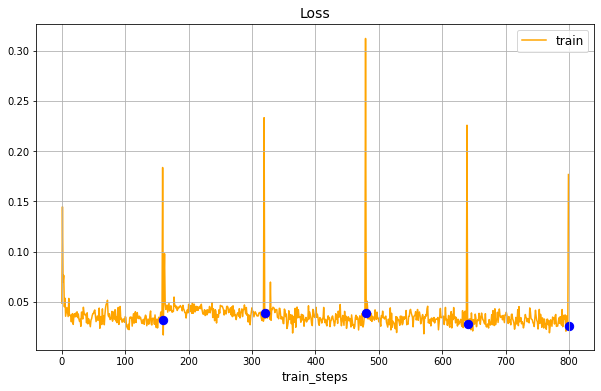

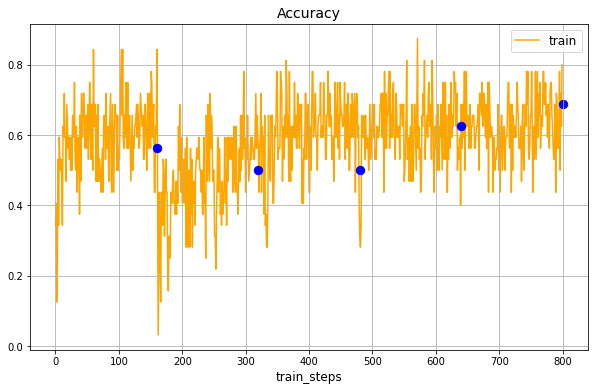

Iteration: 4
Train_loss: 0.036036170527804647, 0.034470741588156675, 0.03262948081130162
Train_accuracy: 0.6062109375, 0.6128515625000001, 0.6284375
Val_loss: 0.03886263817548752, 0.027634648606181145, 0.02603764645755291
Val_accuracy: 0.5, 0.625, 0.6875
F1_score: 0.3051282051282051, 0.291812865497076, 0.3263736263736264


In [53]:
## Попробуем обучить собственную модель VGGNet из 6 базовых блоков с нуля на 5 эпохах , без аугментации
my_vgg = my_VGGNet(num_blocks=6, num_classes=5)
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, f1_list = train_net(my_vgg, trainset_1, 
                                                                                                        valset_1, batch_size=32, num_epoch=5)

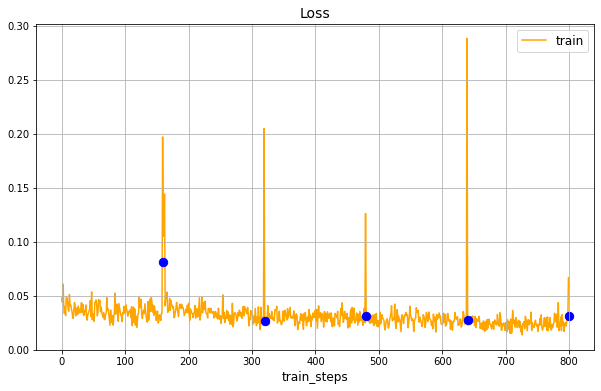

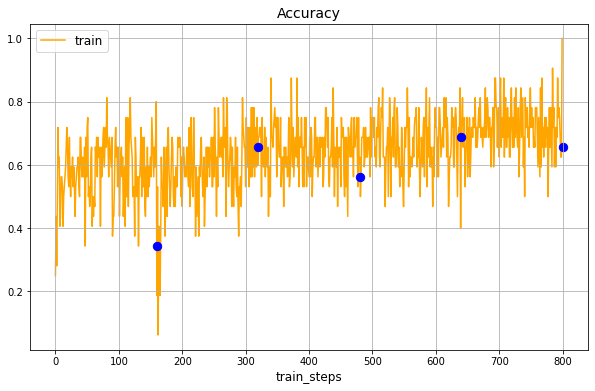

Iteration: 4
Train_loss: 0.030598111485596748, 0.029496930914465334, 0.024552517815027385
Train_accuracy: 0.647109375, 0.6667578125, 0.7169921875
Val_loss: 0.031173482537269592, 0.027707338333129883, 0.03122669830918312
Val_accuracy: 0.5625, 0.6875, 0.65625
F1_score: 0.3939393939393939, 0.6066666666666667, 0.3882458770614693


In [54]:
## Попробуем обучить собственную модель ResNet из 4 слоев по 2 блока в каждом с нуля на 5 эпохах, без аугментации
my_resnet = my_ResNet(BasicRedusialBlock, [2, 2, 2, 2], num_classes=5)
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, f1_list = train_net(my_resnet, trainset_1, 
                                                                                                        valset_1, batch_size=32, num_epoch=5)

Собственные модели отработали премерно одинаково и видим, что качество растет не слишком хорошо

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


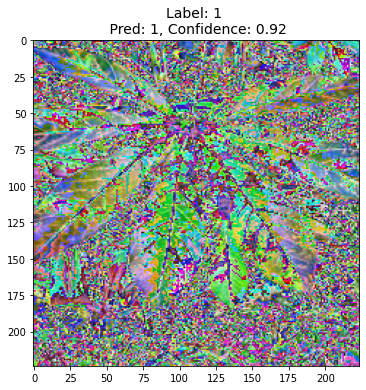

In [109]:
## Отобразим на сколько уверена наша модель в своих предсказаниях
## Можно заметить, что модель часто ошибается
plot_images(my_resnet, valset_1)

Дальше будем использовать модели предобученные на ImageNet

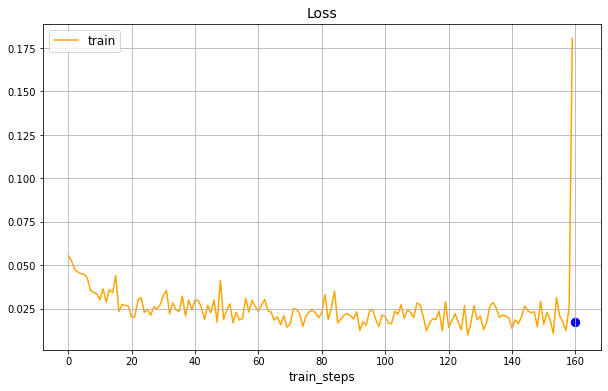

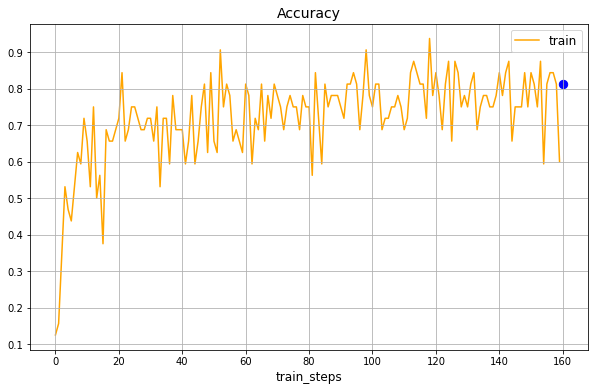

Iteration: 0
Train_loss: 0.025196236512856556
Train_accuracy: 0.72328125
Val_loss: 0.01741056889295578
Val_accuracy: 0.8125
F1_score: 0.6418550724637682


In [111]:
## Возьмем предобученную сеть resnet50 и переобучем ее последний сверточный блок на нашем датасете
##  Датасет с фотографиями 224х224 с аугментацией
resnet_50 = resnet50(pretrained=True)
for param in resnet_50.parameters():
  param.requires_gard = False
resnet_50.fc = nn.Linear(2048, 5)
for param in resnet_50.fc.parameters():
  param.requires_gard = True
for param in resnet_50.layer4.parameters():
  param.requires_grad = True
for param in resnet_50.layer3.parameters():
  param.requires_gard = False
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, f1_list = train_net(resnet_50, trainset_2, valset_1,
                                                                                                        batch_size=32, num_epoch=1)

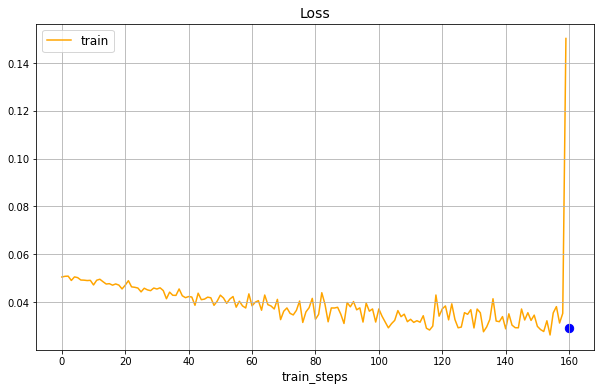

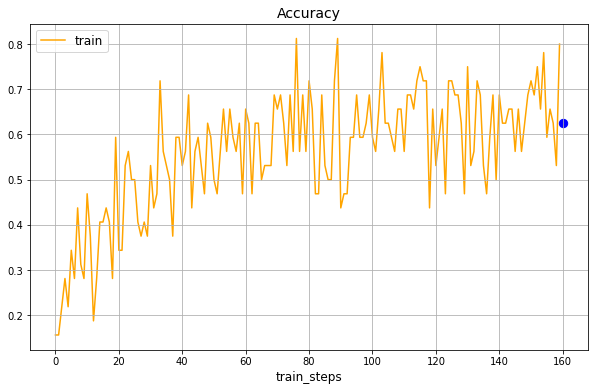

Iteration: 0
Train_loss: 0.03918263897299766
Train_accuracy: 0.5602734375
Val_loss: 0.028948280960321426
Val_accuracy: 0.625
F1_score: 0.33777777777777773


In [113]:
## Возьмем предобученную сеть EfficentNet_B4 и переобучем ее  3 последних сверточных блока на нашем датасете
##  Датасет с фотографиями 224х224 с аугментацией
Efficentnet_b4 = EfficientNet.from_pretrained("efficientnet-b4", advprop=False)
for param in Efficentnet_b4.parameters():
    param.requires_grad = False
Efficentnet_b4._fc = nn.Linear(1792, 5)
for param in Efficentnet_b4._blocks[31].parameters():
    param.requires_grad = True
for param in Efficentnet_b4._blocks[30].parameters():
    param.requires_grad = True
for param in Efficentnet_b4._blocks[29].parameters():
    param.requires_grad = True
for param in Efficentnet_b4._fc.parameters():
    param.requiers_grad = True
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, f1_list = train_net(Efficentnet_b4, trainset_2, valset_1,
                                                                                                        batch_size=32, num_epoch=1)

##### Максимальный результат, которого удалось добиться на тестовой выборке, используя модели resnet50 и Efficentnet_B4 на данных датасетах не превысил accuracy = 85,5%

In [ ]:
## Модель resnet152 на датасете 224х224 с аугментацией с понижением learning_rate во время обучения
resnet_152 = resnet152(pretrained=True)
for param in resnet_152.parameters():
  param.requires_gard = False
resnet_152.fc = nn.Linear(2048, 5)
for param in resnet_152.fc.parameters():
  param.requires_gard = True
for param in resnet_152.layer4.parameters():
  param.requires_grad = True
for param in resnet_152.layer3.parameters():
  param.requires_gard = False
train_net(resnet152, trainset_2, valset_1, batch_size=32, num_epoch=15, learning_rate=5e-5)
train_net(resnet152, trainset_2, valset_1, batch_size=32, num_epoch=1, learning_rate=1e-5)
train_net(resnet152, trainset_2, valset_1, batch_size=32, num_epoch=1, learning_rate=5e-6)
train_net(resnet152, trainset_2, valset_1, batch_size=32, num_epoch=3, learning_rate=1e-6)

In [ ]:
## Модель resnet50 на датасете 448х448 с аугментацией с понижением learning_rate во время обучения
resnet_50 = resnet50(pretrained=True)
for param in resnet_50.parameters():
  param.requires_gard = False
resnet_50.fc = nn.Linear(2048, 5)
for param in resnet_50.fc.parameters():
  param.requires_gard = True
for param in resnet_50.layer4.parameters():
  param.requires_grad = True
for param in resnet_50.layer3.parameters():
  param.requires_gard = False
train_net(resnet_50, trainset_3, valset_3_1, batch_size=32, num_epoch=9, learning_rate=5e-4)
train_net(resnet_50, trainset_3, valset_3_1, batch_size=32, num_epoch=1, learning_rate=1e-5)
train_net(resnet_50, trainset_3, valset_3_1, batch_size=32, num_epoch=1, learning_rate=5e-6)
train_net(resnet_50, trainset_3, valset_3_1, batch_size=32, num_epoch=2, learning_rate=1e-6)

In [ ]:
pred, path = predict(resnet_50, testset, batch_size=32)
df_result = pd.read_csv(sample_submission_path)
df_result.Category = pred
df_result.Id = path
df_result.to_csv('submission.csv', index = False)

## 4. Оценка результатов

### Лучшие модели:

#### 1.  ResNet152 предобученная на ImageNet: публичная оценка: accuracy = 87.35%, приватная оценка: accuracy = 88.78%
- Фотографии размера 224х224
- Агментация: transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.6),
                                                          transforms.GaussianBlur(7)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05))
- Переобучение последнего блока модели на нашем датасете
- Обучение с понижением learning_rate

#### 2. ResNet50 предобученная на ImageNet: публичная оценка: accuracy = 89.20%, приватная оценка: accuracy = 90.41%
- Фотографии размера 448х448
- Агментация: transforms.RandomHorizontalFlip(0.5),
                                  transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomApply([transforms.ColorJitter(0.8, 0.5, 0.6),
                                                          transforms.GaussianBlur(3)], 0.5),
                                  transforms.RandomRotation(15),
                                  transforms.RandomErasing(scale=(0.05, 0.05))
- Переобучение последнего блока модели на нашем датасете
- Обучение с понижением learning_rate            